# Mutation analysis of AY.25

In [1]:
import pandas as pd
import genomics_data_index.api as gdi
import genomics_data_index

print(genomics_data_index.__version__)
db = gdi.GenomicsDataIndex.connect('index')
db

0.4.0.dev1


<GenomicsDataIndex(samples=15134)>

In [2]:
db.reference_names()

['NC_045512']

# Load metadata

In [3]:
metadata_df = pd.read_csv('input/twentyfiveext_subsampled_metadata.tsv.gz', sep='\t')
metadata_df['is_canada'] = metadata_df['country'] == 'Canada'
metadata_df['pango_lineage_location'] = metadata_df['pango_lineage'] + '_Not_Canada'
metadata_df.loc[metadata_df['is_canada'], 'pango_lineage_location'] = metadata_df['pango_lineage'] + '_Canada'
metadata_df['date'] = metadata_df['date'].astype('datetime64')
metadata_df['strain'].head(3)

0    Aruba/AW-RIVM-58329/2021
1    Aruba/AW-RIVM-58340/2021
2    Aruba/AW-RIVM-53976/2021
Name: strain, dtype: object

In [4]:
metadata_df[metadata_df['pango_lineage'] == 'AY.25']['country'].value_counts()

Canada                    7547
USA                       3906
Chile                     1254
Aruba                      481
United Kingdom             347
                          ... 
Martinique                   1
Guadeloupe                   1
Republic of the Congo        1
Bosnia and Herzegovina       1
Grenada                      1
Name: country, Length: 65, dtype: int64

In [5]:
metadata_df['pango_lineage_location'].value_counts().head(5)

AY.25_Canada            7547
AY.25_Not_Canada        7505
B.1.1.7_Not_Canada        15
B.1.617.2_Not_Canada       9
B.1_Not_Canada             7
Name: pango_lineage_location, dtype: int64

In [6]:
metadata_df['is_canada'].value_counts()

False    7587
True     7547
Name: is_canada, dtype: int64

In [7]:
metadata_df[metadata_df['pango_lineage'] == 'AY.25']['is_canada'].value_counts()

True     7547
False    7505
Name: is_canada, dtype: int64

In [8]:
metadata_df.columns

Index(['strain', 'gisaid_epi_isl', 'date', 'region', 'country', 'division',
       'pango_lineage', 'purpose_of_sequencing', 'region_exposure',
       'country_exposure', 'division_exposure', 'virus', 'genbank_accession',
       'location', 'segment', 'length', 'host', 'age', 'sex', 'GISAID_clade',
       'originating_lab', 'submitting_lab', 'authors', 'url', 'title',
       'paper_url', 'date_submitted', 'sampling_strategy', 'can', 'worldwide',
       'is_canada', 'pango_lineage_location'],
      dtype='object')

# Load tree

## Time tree

In [9]:
from ete3 import Tree

reference_name = 'Wuhan/Hu-1/2019' # Confirmed this is identical to NC_045512
delta_tree = Tree('tree.nwk', format=1)
delta_tree.get_leaf_names()[0:5]

['Wuhan/Hu-1/2019',
 'SouthKorea/KCDC2061/2020',
 'Panama/335931/2020',
 'Guatemala/GUA-LNS-1056/2021',
 'Panama/GMI-PA419159/2020']

# Load reference

In [10]:
from Bio import SeqIO
import gzip

with gzip.open('../references/NC_045512.gbk.gz', 'rt') as fh:
    records = list(SeqIO.parse(fh, 'genbank'))

record = records[0]
reference_length = len(record.seq)
print(f'{record.id} is {reference_length} bp')

NC_045512.2 is 29903 bp


# Join to metadata and delta tree

## Time tree

In [11]:
q = db.samples_query(reference_name='NC_045512', universe='mutations')
q

<SamplesQueryIndex[selected=100% (15134/15134) samples, unknown=0% (0/15134) samples]>

In [12]:
t = q.join_tree(delta_tree, alignment_length=reference_length, kind='mutation', reference_name=reference_name)\
     .join(metadata_df, sample_names_column='strain').reset_universe()
t = t.set_outgroup(reference_name)
t

Passed tree has 15134 leaves, but only 15135 match samples in the system. Pruning tree to match samples in system.


<MutationTreeSamplesQuery[selected=100% (15134/15134) samples, unknown=0% (0/15134) samples]>

# Compare AY.25 inside and outside Canada

In [13]:
t25 = t.isa(r'^AY.25', regex=True, isa_column='pango_lineage', kind='dataframe')
t25

<MutationTreeSamplesQuery[selected=99% (15052/15134) samples, unknown=0% (0/15134) samples]>

In [14]:
t25.toframe()['pango_lineage'].value_counts()

AY.25    15052
Name: pango_lineage, dtype: int64

In [15]:
t25.toframe()['is_canada'].value_counts()

True     7547
False    7505
Name: is_canada, dtype: int64

In [16]:
comparison_canada_df = t25.features_comparison(sample_categories='is_canada',
                      categories_kind='dataframe',
                      kind='mutations',
                      unit='proportion',
                      category_samples_threshold=5,
                      )
comparison_canada_df = comparison_canada_df.rename({
    'True_proportion': 'is_canada_proportion',
    'False_proportion': 'is_not_canada_proportion',
    'True_total': 'is_canada_total',
    'False_total': 'is_not_canada_total',
}, axis='columns')
comparison_canada_df['difference'] = comparison_canada_df['is_canada_proportion'] - comparison_canada_df['is_not_canada_proportion']
comparison_canada_df

,Sequence,Position,Deletion,Insertion,Type,Total,is_not_canada_proportion,is_canada_proportion,is_not_canada_total,is_canada_total,...,Gene_ID,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p,difference
Mutation,,,,,,,,,,,,,,,,,,,,,
NC_045512.2:21590:C:T,NC_045512.2,21590,C,T,SNP,15052,0.000133,0.000000,7505,7547,...,GU280_gp02,transcript,protein_coding,c.28C>T,p.L10L,hgvs:NC_045512.2:GU280_gp02:c.28C>T,hgvs:NC_045512.2:GU280_gp02:p.L10L,hgvs_gn:NC_045512.2:S:c.28C>T,hgvs_gn:NC_045512.2:S:p.L10L,-0.000133
NC_045512.2:3926:T:G,NC_045512.2,3926,T,G,SNP,15052,0.000133,0.000000,7505,7547,...,GU280_gp01,transcript,protein_coding,c.1207T>G,p.S403A,hgvs:NC_045512.2:GU280_gp01:c.1207T>G,hgvs:NC_045512.2:GU280_gp01:p.S403A,hgvs_gn:NC_045512.2:ORF1ab:c.1207T>G,hgvs_gn:NC_045512.2:ORF1ab:p.S403A,-0.000133
NC_045512.2:2346:T:C,NC_045512.2,2346,T,C,SNP,15052,0.021586,0.000265,7505,7547,...,GU280_gp01,transcript,protein_coding,c.1541T>C,p.I514T,hgvs:NC_045512.2:GU280_gp01:c.1541T>C,hgvs:NC_045512.2:GU280_gp01:p.I514T,hgvs_gn:NC_045512.2:ORF1ab:c.1541T>C,hgvs_gn:NC_045512.2:ORF1ab:p.I514T,-0.021321
NC_045512.2:19737:T:C,NC_045512.2,19737,T,C,SNP,15052,0.000133,0.000000,7505,7547,...,GU280_gp01,transcript,protein_coding,c.117T>C,p.D39D,hgvs:NC_045512.2:GU280_gp01:c.117T>C,hgvs:NC_045512.2:GU280_gp01:p.D39D,hgvs_gn:NC_045512.2:ORF1ab:c.117T>C,hgvs_gn:NC_045512.2:ORF1ab:p.D39D,-0.000133
NC_045512.2:27047:G:A,NC_045512.2,27047,G,A,SNP,15052,0.000400,0.000530,7505,7547,...,GU280_gp05,transcript,protein_coding,c.525G>A,p.T175T,hgvs:NC_045512.2:GU280_gp05:c.525G>A,hgvs:NC_045512.2:GU280_gp05:p.T175T,hgvs_gn:NC_045512.2:M:c.525G>A,hgvs_gn:NC_045512.2:M:p.T175T,0.000130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC_045512.2:15743:G:T,NC_045512.2,15743,G,T,SNP,15052,0.000000,0.000133,7505,7547,...,GU280_gp01,transcript,protein_coding,c.15479G>T,p.S5160I,hgvs:NC_045512.2:GU280_gp01:c.15479G>T,hgvs:NC_045512.2:GU280_gp01:p.S5160I,hgvs_gn:NC_045512.2:ORF1ab:c.15479G>T,hgvs_gn:NC_045512.2:ORF1ab:p.S5160I,0.000133
NC_045512.2:17364:T:C,NC_045512.2,17364,T,C,SNP,15052,0.000133,0.000000,7505,7547,...,GU280_gp01,transcript,protein_coding,c.1128T>C,p.I376I,hgvs:NC_045512.2:GU280_gp01:c.1128T>C,hgvs:NC_045512.2:GU280_gp01:p.I376I,hgvs_gn:NC_045512.2:ORF1ab:c.1128T>C,hgvs_gn:NC_045512.2:ORF1ab:p.I376I,-0.000133
NC_045512.2:20685:T:C,NC_045512.2,20685,T,C,SNP,15052,0.000133,0.000000,7505,7547,...,GU280_gp01,transcript,protein_coding,c.20421T>C,p.V6807V,hgvs:NC_045512.2:GU280_gp01:c.20421T>C,hgvs:NC_045512.2:GU280_gp01:p.V6807V,hgvs_gn:NC_045512.2:ORF1ab:c.20421T>C,hgvs_gn:NC_045512.2:ORF1ab:p.V6807V,-0.000133


In [17]:
def setup_id(df: pd.DataFrame, hgvs_p_col: str) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy['HGVS.p'] = df_copy['HGVS.p'].fillna('<NA>')
    df_copy['ID'] = df_copy['Gene_Name'] + ':' \
      + df_copy['HGVS.p'].str.replace(r'^p.','', regex=True) \
      + '_(g.' + df_copy['Position'].astype(str) + df_copy['Deletion'] + '>' + df_copy['Insertion'] + ')'
    df_copy['SPDI'] = df_copy.index
    
    return df_copy

diff_canada_df = setup_id(comparison_canada_df, hgvs_p_col='HGVS.p')
diff_canada_df

,Sequence,Position,Deletion,Insertion,Type,Total,is_not_canada_proportion,is_canada_proportion,is_not_canada_total,is_canada_total,...,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p,difference,ID,SPDI
Mutation,,,,,,,,,,,,,,,,,,,,,
NC_045512.2:21590:C:T,NC_045512.2,21590,C,T,SNP,15052,0.000133,0.000000,7505,7547,...,protein_coding,c.28C>T,p.L10L,hgvs:NC_045512.2:GU280_gp02:c.28C>T,hgvs:NC_045512.2:GU280_gp02:p.L10L,hgvs_gn:NC_045512.2:S:c.28C>T,hgvs_gn:NC_045512.2:S:p.L10L,-0.000133,S:L10L_(g.21590C>T),NC_045512.2:21590:C:T
NC_045512.2:3926:T:G,NC_045512.2,3926,T,G,SNP,15052,0.000133,0.000000,7505,7547,...,protein_coding,c.1207T>G,p.S403A,hgvs:NC_045512.2:GU280_gp01:c.1207T>G,hgvs:NC_045512.2:GU280_gp01:p.S403A,hgvs_gn:NC_045512.2:ORF1ab:c.1207T>G,hgvs_gn:NC_045512.2:ORF1ab:p.S403A,-0.000133,ORF1ab:S403A_(g.3926T>G),NC_045512.2:3926:T:G
NC_045512.2:2346:T:C,NC_045512.2,2346,T,C,SNP,15052,0.021586,0.000265,7505,7547,...,protein_coding,c.1541T>C,p.I514T,hgvs:NC_045512.2:GU280_gp01:c.1541T>C,hgvs:NC_045512.2:GU280_gp01:p.I514T,hgvs_gn:NC_045512.2:ORF1ab:c.1541T>C,hgvs_gn:NC_045512.2:ORF1ab:p.I514T,-0.021321,ORF1ab:I514T_(g.2346T>C),NC_045512.2:2346:T:C
NC_045512.2:19737:T:C,NC_045512.2,19737,T,C,SNP,15052,0.000133,0.000000,7505,7547,...,protein_coding,c.117T>C,p.D39D,hgvs:NC_045512.2:GU280_gp01:c.117T>C,hgvs:NC_045512.2:GU280_gp01:p.D39D,hgvs_gn:NC_045512.2:ORF1ab:c.117T>C,hgvs_gn:NC_045512.2:ORF1ab:p.D39D,-0.000133,ORF1ab:D39D_(g.19737T>C),NC_045512.2:19737:T:C
NC_045512.2:27047:G:A,NC_045512.2,27047,G,A,SNP,15052,0.000400,0.000530,7505,7547,...,protein_coding,c.525G>A,p.T175T,hgvs:NC_045512.2:GU280_gp05:c.525G>A,hgvs:NC_045512.2:GU280_gp05:p.T175T,hgvs_gn:NC_045512.2:M:c.525G>A,hgvs_gn:NC_045512.2:M:p.T175T,0.000130,M:T175T_(g.27047G>A),NC_045512.2:27047:G:A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC_045512.2:15743:G:T,NC_045512.2,15743,G,T,SNP,15052,0.000000,0.000133,7505,7547,...,protein_coding,c.15479G>T,p.S5160I,hgvs:NC_045512.2:GU280_gp01:c.15479G>T,hgvs:NC_045512.2:GU280_gp01:p.S5160I,hgvs_gn:NC_045512.2:ORF1ab:c.15479G>T,hgvs_gn:NC_045512.2:ORF1ab:p.S5160I,0.000133,ORF1ab:S5160I_(g.15743G>T),NC_045512.2:15743:G:T
NC_045512.2:17364:T:C,NC_045512.2,17364,T,C,SNP,15052,0.000133,0.000000,7505,7547,...,protein_coding,c.1128T>C,p.I376I,hgvs:NC_045512.2:GU280_gp01:c.1128T>C,hgvs:NC_045512.2:GU280_gp01:p.I376I,hgvs_gn:NC_045512.2:ORF1ab:c.1128T>C,hgvs_gn:NC_045512.2:ORF1ab:p.I376I,-0.000133,ORF1ab:I376I_(g.17364T>C),NC_045512.2:17364:T:C
NC_045512.2:20685:T:C,NC_045512.2,20685,T,C,SNP,15052,0.000133,0.000000,7505,7547,...,protein_coding,c.20421T>C,p.V6807V,hgvs:NC_045512.2:GU280_gp01:c.20421T>C,hgvs:NC_045512.2:GU280_gp01:p.V6807V,hgvs_gn:NC_045512.2:ORF1ab:c.20421T>C,hgvs_gn:NC_045512.2:ORF1ab:p.V6807V,-0.000133,ORF1ab:V6807V_(g.20685T>C),NC_045512.2:20685:T:C


In [18]:
def fix_ids(original_df: pd.DataFrame, subset_df: pd.DataFrame) -> pd.DataFrame:
    """
    Fixes HGVS.p identifiers to correspond to proper location (mainly beginning of ORF1ab)
    Each of these was verified as being the proper name by examining the VCF and Genbank files
    """
    
    mutations_list = subset_df['Mutation'].tolist()
    original_df_copy = original_df.loc[mutations_list]
    
    original_df_copy.loc[
        original_df['ID_HGVS_GN.p'] == 'hgvs_gn:NC_045512.2:ORF1ab:p.D410G', 'HGVS.p'] = 'p.D1228G'
    original_df_copy.loc[
        original_df['ID_HGVS_GN.p'] == 'hgvs_gn:NC_045512.2:ORF1ab:p.E587K', 'HGVS.p'] = 'p.E767K'
    
    original_df_copy = setup_id(original_df_copy, hgvs_p_col='HGVS.p')
    original_df_copy = original_df_copy['ID']
    
    subset_df = subset_df.set_index('Mutation')
    subset_df = subset_df.merge(original_df_copy, left_index=True, right_index=True)
    subset_df = subset_df.drop(['ID_HGVS_GN.p', 'ID_HGVS_GN.c'], axis='columns')
    
    return subset_df.reset_index().set_index('ID')

threshold_proportion_diff = 0.15

small_canada_df = diff_canada_df[['is_canada_proportion', 'is_not_canada_proportion', 'difference', 'Position', 'ID_HGVS_GN.p', 'ID_HGVS_GN.c', 'ID']]\
 .sort_values('difference', ascending=True)
small_canada_df = small_canada_df[abs(small_canada_df['difference']) >= threshold_proportion_diff]
small_canada_df = small_canada_df.reset_index().set_index('ID')
    
small_canada_df = fix_ids(original_df=comparison_canada_df, subset_df=small_canada_df)
small_canada_df

,Mutation,is_canada_proportion,is_not_canada_proportion,difference,Position
ID,,,,,
ORF1ab:E767K_(g.2564G>A),NC_045512.2:2564:G:A,0.001325,0.247568,-0.246243,2564
S:S112L_(g.21897C>T),NC_045512.2:21897:C:T,0.004638,0.165889,-0.161252,21897
ORF1ab:P6657L_(g.20234C>T),NC_045512.2:20234:C:T,0.341593,0.003731,0.337862,20234
ORF1ab:C3766F_(g.11562G>T),NC_045512.2:11562:G:T,0.986087,0.639973,0.346114,11562
ORF1ab:D1228G_(g.3948A>G),NC_045512.2:3948:A:G,0.986617,0.627049,0.359569,3948
S:G142D_(g.21987G>A),NC_045512.2:21987:G:A,0.984630,0.556029,0.428600,21987


In [19]:
t25_only = t25.reset_universe()
t25_only_canada = t25_only.isa('Canada', isa_column='country', kind='dataframe')
t25_only_not_canada = ~t25_only_canada

total_t25 = len(t25_only)
proportion_data = []
for mutation in small_canada_df['Mutation'].tolist():
    is_canada_mutation = t25_only_canada.hasa(mutation)
    is_not_canada_mutation = t25_only_not_canada.hasa(mutation)
    
    is_canada_proportion = len(is_canada_mutation) / len(t25_only_canada)
    is_canada_unknown = len(is_canada_mutation.unknown_set) / len(t25_only_canada)
    is_not_canada_proportion = len(is_not_canada_mutation) / len(t25_only_not_canada)
    is_not_canada_unknown = len(is_not_canada_mutation.unknown_set) / len(t25_only_not_canada)
    
    proportion_data.append([mutation, is_canada_proportion, is_canada_unknown,
                           is_not_canada_proportion, is_not_canada_unknown])

canada_unknowns_df = pd.DataFrame(proportion_data,
                                 columns=['Mutation_ID', 'is_canada_isa_proportion', 'is_canada_isa_unknown',
                                         'is_not_canada_isa_proportion', 'is_not_canada_isa_unknown'])
canada_unknowns_df

,Mutation_ID,is_canada_isa_proportion,is_canada_isa_unknown,is_not_canada_isa_proportion,is_not_canada_isa_unknown
0,NC_045512.2:2564:G:A,0.001325,0.000000,0.247568,0.001999
1,NC_045512.2:21897:C:T,0.004638,0.013118,0.165889,0.203065
2,NC_045512.2:20234:C:T,0.341593,0.003048,0.003731,0.008528
3,NC_045512.2:11562:G:T,0.986087,0.001458,0.639973,0.006262
4,NC_045512.2:3948:A:G,0.986617,0.000663,0.627049,0.004264
5,NC_045512.2:21987:G:A,0.984630,0.015370,0.556029,0.206129


In [20]:
small_canada_unknown_df = small_canada_df.reset_index().merge(canada_unknowns_df, left_on='Mutation', right_on='Mutation_ID', how='inner')
small_canada_unknown_df = small_canada_unknown_df.set_index('ID')

if ((not all(small_canada_unknown_df['is_canada_proportion'] == small_canada_unknown_df['is_canada_isa_proportion'])) or 
   (not all(small_canada_unknown_df['is_not_canada_proportion'] == small_canada_unknown_df['is_not_canada_isa_proportion']))):
        raise Exception('Proportions not equal')
        
small_canada_unknown_df

,Mutation,is_canada_proportion,is_not_canada_proportion,difference,Position,Mutation_ID,is_canada_isa_proportion,is_canada_isa_unknown,is_not_canada_isa_proportion,is_not_canada_isa_unknown
ID,,,,,,,,,,
ORF1ab:E767K_(g.2564G>A),NC_045512.2:2564:G:A,0.001325,0.247568,-0.246243,2564,NC_045512.2:2564:G:A,0.001325,0.000000,0.247568,0.001999
S:S112L_(g.21897C>T),NC_045512.2:21897:C:T,0.004638,0.165889,-0.161252,21897,NC_045512.2:21897:C:T,0.004638,0.013118,0.165889,0.203065
ORF1ab:P6657L_(g.20234C>T),NC_045512.2:20234:C:T,0.341593,0.003731,0.337862,20234,NC_045512.2:20234:C:T,0.341593,0.003048,0.003731,0.008528
ORF1ab:C3766F_(g.11562G>T),NC_045512.2:11562:G:T,0.986087,0.639973,0.346114,11562,NC_045512.2:11562:G:T,0.986087,0.001458,0.639973,0.006262
ORF1ab:D1228G_(g.3948A>G),NC_045512.2:3948:A:G,0.986617,0.627049,0.359569,3948,NC_045512.2:3948:A:G,0.986617,0.000663,0.627049,0.004264
S:G142D_(g.21987G>A),NC_045512.2:21987:G:A,0.984630,0.556029,0.428600,21987,NC_045512.2:21987:G:A,0.984630,0.015370,0.556029,0.206129


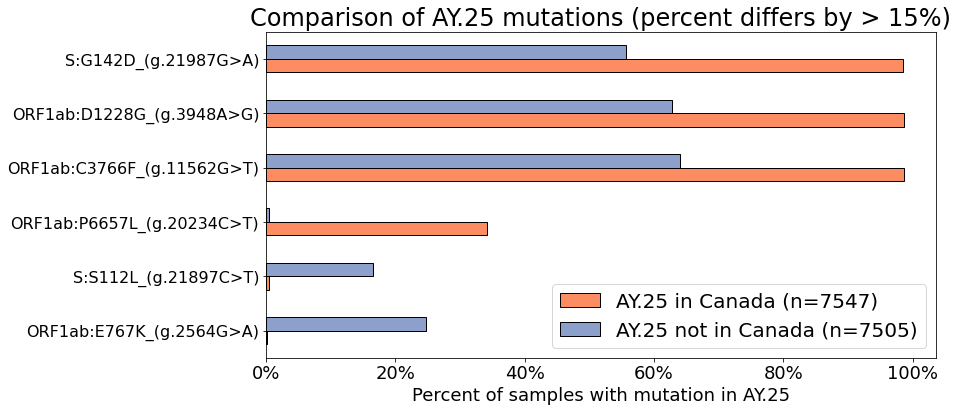

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

num_canada = comparison_canada_df['is_canada_total'].value_counts().index[0]
num_not_canada = comparison_canada_df['is_not_canada_total'].value_counts().index[0]
name_canada = f'AY.25 in Canada (n={num_canada})'
name_canada_unknown = f'AY.25 in Canada (n={num_canada})'
name_not_canada = f'AY.25 not in Canada (n={num_not_canada})'

small_plot_df = small_canada_unknown_df.rename({
    'is_canada_proportion': name_canada,
    'is_not_canada_proportion': name_not_canada,
}, axis='columns')

small_plot_unknown_df = small_canada_unknown_df.rename({
    'is_canada_isa_unknown': name_canada,
    'is_not_canada_isa_unknown': name_not_canada,
}, axis='columns')

ax = small_plot_df[[name_canada, name_not_canada]].plot(kind='barh', figsize=(12,6), edgecolor='black',
                                                       color=['#fc8d62', '#8da0cb'])

plt.legend(prop={'size': 20}, loc='lower right')
plt.title(f'Comparison of AY.25 mutations (percent differs by > {threshold_proportion_diff*100:0.0f}%)', fontdict={'size': 24})
plt.xlabel(f'Percent of samples with mutation in AY.25', fontdict={'size': 18})
plt.xticks(fontsize=18)
plt.ylabel('')
plt.yticks(fontsize=16)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

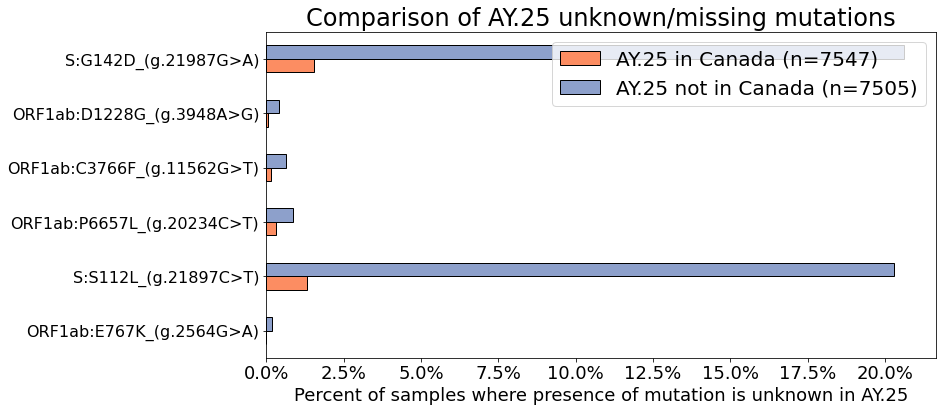

In [22]:
ax = small_plot_unknown_df[[name_canada, name_not_canada]].plot(kind='barh', figsize=(12,6), edgecolor='black',
                                                       color=['#fc8d62', '#8da0cb'])

plt.legend(prop={'size': 20}, loc='upper right')
plt.title(f'Comparison of AY.25 unknown/missing mutations', fontdict={'size': 24})
plt.xlabel(f'Percent of samples where presence of mutation is unknown in AY.25', fontdict={'size': 18})
plt.xticks(fontsize=18)
plt.ylabel('')
plt.yticks(fontsize=16)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

In [23]:
from typing import List

def look_for_positions_around(features_df: pd.DataFrame, positions: List[int]):
    position_threshold = 10
    for pos in positions:
        df = features_df[(features_df['Position'] > pos - position_threshold) & (features_df['Position'] < pos + position_threshold)]
        print(f'\nFeatures around position={pos}')
        print(df[['Position', 'Count', 'ID_HGVS_GN.p']])

t25_df = t25.features_summary().sort_values('Position', ascending=True)
look_for_positions_around(t25_df, positions=small_canada_df['Position'].tolist())


Features around position=2564
                      Position  Count                        ID_HGVS_GN.p
Mutation                                                                 
NC_045512.2:2564:G:A      2564   1868  hgvs_gn:NC_045512.2:ORF1ab:p.E587K
NC_045512.2:2568:A:T      2568      1  hgvs_gn:NC_045512.2:ORF1ab:p.Q588L
NC_045512.2:2569:A:G      2569      5  hgvs_gn:NC_045512.2:ORF1ab:p.Q588Q
NC_045512.2:2570:C:T      2570      2  hgvs_gn:NC_045512.2:ORF1ab:p.P589S

Features around position=21897
                       Position  Count                   ID_HGVS_GN.p
Mutation                                                             
NC_045512.2:21893:G:C     21893      1  hgvs_gn:NC_045512.2:S:p.D111H
NC_045512.2:21897:C:T     21897   1280  hgvs_gn:NC_045512.2:S:p.S112L
NC_045512.2:21898:G:T     21898      2  hgvs_gn:NC_045512.2:S:p.S112S

Features around position=20234
                       Position  Count                         ID_HGVS_GN.p
Mutation                           

# Tree

In [24]:
canadian_elevated_df = small_canada_df[small_canada_df['difference'] >= 0].sort_values('is_canada_proportion', ascending=False)
ay25_mutations_list_canadian = canadian_elevated_df['Mutation'].tolist()
canadian_elevated_df

,Mutation,is_canada_proportion,is_not_canada_proportion,difference,Position
ID,,,,,
ORF1ab:D1228G_(g.3948A>G),NC_045512.2:3948:A:G,0.986617,0.627049,0.359569,3948
ORF1ab:C3766F_(g.11562G>T),NC_045512.2:11562:G:T,0.986087,0.639973,0.346114,11562
S:G142D_(g.21987G>A),NC_045512.2:21987:G:A,0.984630,0.556029,0.428600,21987
ORF1ab:P6657L_(g.20234C>T),NC_045512.2:20234:C:T,0.341593,0.003731,0.337862,20234


In [25]:
non_canadian_elevated_df = small_canada_df[small_canada_df['difference'] < 0].sort_values('is_not_canada_proportion', ascending=False)
ay25_mutations_list_non_canadian = non_canadian_elevated_df['Mutation'].tolist()
non_canadian_elevated_df

,Mutation,is_canada_proportion,is_not_canada_proportion,difference,Position
ID,,,,,
ORF1ab:E767K_(g.2564G>A),NC_045512.2:2564:G:A,0.001325,0.247568,-0.246243,2564
S:S112L_(g.21897C>T),NC_045512.2:21897:C:T,0.004638,0.165889,-0.161252,21897


In [26]:
canadian_elevated_colors = ['#a50f15', '#de2d26', '#fb6a4a', '#fcae91']
ay25_mutations_mod = {m:c for (m,c) in zip(ay25_mutations_list_canadian, canadian_elevated_colors)}

non_canadian_elevated_colors = ['#3182bd', '#9ecae1']
tmp_dict = {m:c for (m,c) in zip(ay25_mutations_list_non_canadian, non_canadian_elevated_colors)}
ay25_mutations_mod.update(tmp_dict)

ay25_mutations_mod

{'NC_045512.2:3948:A:G': '#a50f15',
 'NC_045512.2:11562:G:T': '#de2d26',
 'NC_045512.2:21987:G:A': '#fb6a4a',
 'NC_045512.2:20234:C:T': '#fcae91',
 'NC_045512.2:2564:G:A': '#3182bd',
 'NC_045512.2:21897:C:T': '#9ecae1'}

In [27]:
ay25_mutations_dict_mod = small_canada_df.reset_index().set_index('Mutation')['ID'].to_dict()
ay25_mutations_dict_mod

{'NC_045512.2:2564:G:A': 'ORF1ab:E767K_(g.2564G>A)',
 'NC_045512.2:21897:C:T': 'S:S112L_(g.21897C>T)',
 'NC_045512.2:20234:C:T': 'ORF1ab:P6657L_(g.20234C>T)',
 'NC_045512.2:11562:G:T': 'ORF1ab:C3766F_(g.11562G>T)',
 'NC_045512.2:3948:A:G': 'ORF1ab:D1228G_(g.3948A>G)',
 'NC_045512.2:21987:G:A': 'S:G142D_(g.21987G>A)'}

In [28]:
from typing import List
from genomics_data_index.api.viewer.TreeStyler import TreeStyler, HighlightStyle

def create_highlight_style(colors: List[str]) -> HighlightStyle:
    fg_colors = colors
    bg_colors = fg_colors
    unknown_fg_color = 'black'
    unknown_bg_color = 'black'
    return HighlightStyle._create_highlights(fg_colors=fg_colors, bg_colors=bg_colors,
                                  unknown_bg_color=unknown_bg_color, unknown_fg_color=unknown_fg_color)

highlight_colors = ['#969696', '#d9d9d9']
location_hstyle = create_highlight_style(highlight_colors)

## Time trees

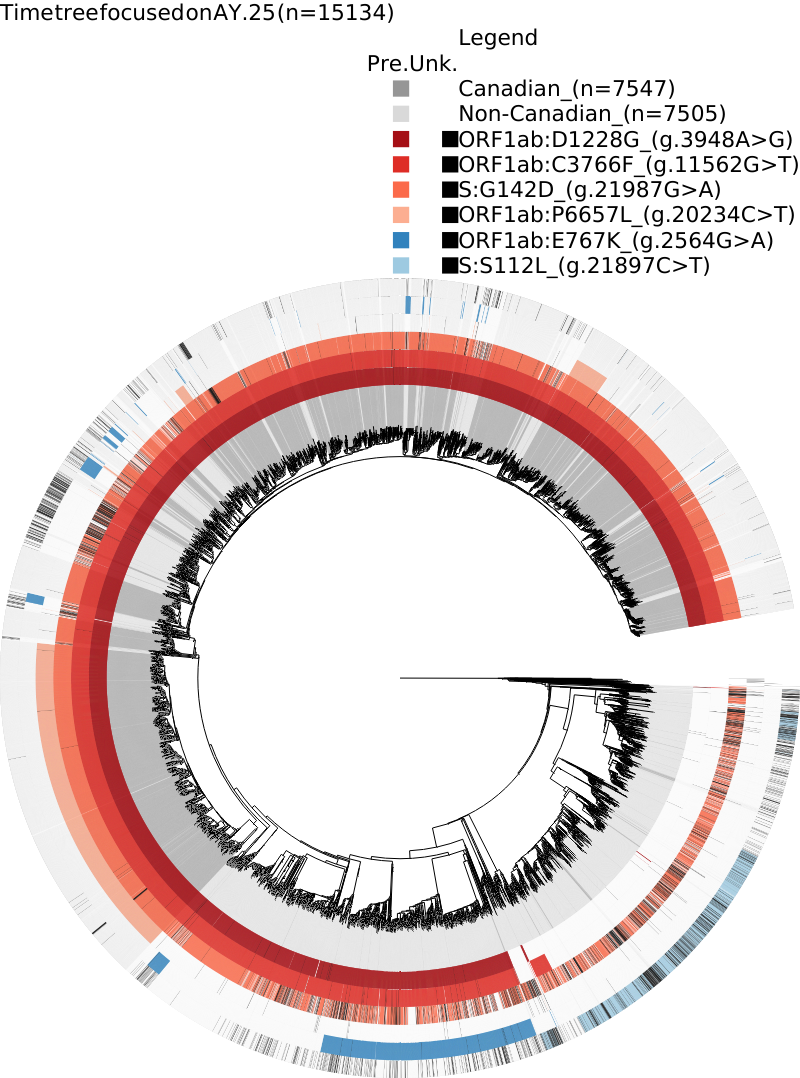

In [29]:
def create_tree_styler(t, tree_scale=33000000,
                       annotate_box_width=6000, annotate_box_height=40,
                       sizes=5500, mode='c'):
    canadian_ay25 = t.isa('AY.25', isa_column='pango_lineage', kind='dataframe') \
                    & t.isa('Canada', isa_column='country', kind='dataframe')

    non_canadian_ay25 = t.isa('AY.25', isa_column='pango_lineage', kind='dataframe') \
                        & ~t.isa('Canada', isa_column='country', kind='dataframe')

    ts = t.tree_styler(mode=mode, highlight_style=location_hstyle,
                       annotate_box_width=annotate_box_width, annotate_box_height=annotate_box_height,
                       legend_nsize=sizes, legend_fsize=sizes,
                       show_leaf_names=False, annotate_guiding_lines=False,
                       annotate_opacity_absent=1.0, annotate_margin=0, annotate_border_color=None,
                       legend_type_label_present='Pre.', legend_type_label_unknown='Unk.',
                       annotate_border_width=None,
                       legend_title='Legend', annotate_show_box_label=False,
                       title=f'Time tree focused on AY.25 (n={len(t)})',
                       title_fsize=sizes,
                       include_unknown=True, annotate_color_unknown='black',
                       tree_scale=tree_scale)\
     .highlight(canadian_ay25, legend_label=f'Canadian_(n={len(canadian_ay25)})')\
     .highlight(non_canadian_ay25, legend_label=f'Non-Canadian_(n={len(non_canadian_ay25)})')

    for mutation in ay25_mutations_list_canadian:
        label = ay25_mutations_dict_mod[mutation]
        color = ay25_mutations_mod[mutation]
        ts = ts.annotate(t.hasa(mutation), legend_label=label, color_present=color)

    for mutation in ay25_mutations_list_non_canadian:
        label = ay25_mutations_dict_mod[mutation]
        color = ay25_mutations_mod[mutation]
        ts = ts.annotate(t.hasa(mutation), legend_label=label, color_present=color)
        
    return ts

# create_tree_styler(t=t).render(w=2400)
create_tree_styler(t=t).render(w=800)

# List of specific identifiers

In [102]:
with open('AY.25-A3948G-G11562T.txt', 'w') as oh:
    samples = t.isa('AY.25', isa_column='pango_lineage', kind='dataframe')\
               .hasa('NC_045512.2:3948:A:G')\
               .hasa('NC_045512.2:11562:G:T')\
               .toframe()[['Sample Name', 'date', 'country']]
    # oh.write('\n'.join(samples))

# Other info

In [56]:
df = t.isa('AY.25', isa_column='pango_lineage', kind='dataframe')\
               .hasa('NC_045512.2:3948:A:G')\
               .hasa('NC_045512.2:11562:G:T')\
               .toframe()

In [69]:
# Earleist
df.iloc[df['date'].sort_values(ascending=True).head(5).index.tolist()][['Query', 'Sample Name', 'Status', 'date', 'country']]

,Query,Sample Name,Status,date,country
9728,join_tree(15134 leaves) AND dataframe(names_co...,Israel/CVL-22309/2021,Present,2021-01-02,Israel
8315,join_tree(15134 leaves) AND dataframe(names_co...,Chile/RM-HCUCH-UNAB-16905059220/2021,Present,2021-01-10,Chile
11839,join_tree(15134 leaves) AND dataframe(names_co...,USA/TN-SPHL-0961/2021,Present,2021-01-14,USA
10807,join_tree(15134 leaves) AND dataframe(names_co...,USA/FL-TGH-2026/2021,Present,2021-02-25,USA
10798,join_tree(15134 leaves) AND dataframe(names_co...,USA/FL-TGH-2030/2021,Present,2021-02-25,USA


In [79]:
df.columns

Index(['Query', 'Sample Name', 'Sample ID', 'Status', 'strain',
       'gisaid_epi_isl', 'date', 'region', 'country', 'division',
       'pango_lineage', 'purpose_of_sequencing', 'region_exposure',
       'country_exposure', 'division_exposure', 'virus', 'genbank_accession',
       'location', 'segment', 'length', 'host', 'age', 'sex', 'GISAID_clade',
       'originating_lab', 'submitting_lab', 'authors', 'url', 'title',
       'paper_url', 'date_submitted', 'sampling_strategy', 'can', 'worldwide',
       'is_canada', 'pango_lineage_location'],
      dtype='object')

In [94]:
countries = df['country'].value_counts().index.tolist()
counts_df_data = []
for c in countries:
    df_sub = df[df['country'] == c].sort_values('date', ascending=True)
    earliest = df_sub['date'].head(1).tolist()[0]
    latest = df_sub['date'].tail(1).tolist()[0]
    count = len(df_sub)
    
    counts_df_data.append([c, count, earliest, latest])
    
counts_df = pd.DataFrame(counts_df_data, columns=['Country', 'Count', 'Earliest', 'Latest'])
counts_df

,Country,Count,Earliest,Latest
0,Canada,7437,2021-04-01,2021-10-18
1,USA,1904,2021-01-14,2021-11-02
2,Chile,1220,2021-01-10,2021-10-30
3,Aruba,470,2021-04-10,2021-10-13
4,Colombia,223,2021-06-08,2021-10-06
5,United Kingdom,161,2021-06-28,2021-10-26
6,Puerto Rico,118,2021-07-10,2021-09-28
7,Peru,85,2021-07-22,2021-10-12
8,Costa Rica,50,2021-07-01,2021-10-12
9,Mexico,49,2021-06-29,2021-10-24


In [96]:
counts_df.to_csv('counts_dates_AY.25-A3948G-G11562T.csv', index=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]),
 [Text(0, 0, 'Curacao'),
  Text(0, 1, 'Guadeloupe'),
  Text(0, 2, 'Grenada'),
  Text(0, 3, 'New Zealand'),
  Text(0, 4, 'Martinique'),
  Text(0, 5, 'Singapore'),
  Text(0, 6, 'Dominican Republic'),
  Text(0, 7, 'Australia'),
  Text(0, 8, 'Ireland'),
  Text(0, 9, 'South Korea'),
  Text(0, 10, 'Belize'),
  Text(0, 11, 'Jamaica'),
  Text(0, 12, 'Montenegro'),
  Text(0, 13, 'Brazil'),
  Text(0, 14, 'Estonia'),
  Text(0, 15, 'Denmark'),
  Text(0, 16, 'Ghana'),
  Text(0, 17, 'The Bahamas'),
  Text(0, 18, 'Hong Kong'),
  Text(0, 19, 'Czech Republic'),
  Text(0, 20, 'Belgium'),
  Text(0, 21, 'Sweden'),
  Text(0, 22, 'Slovakia'),
  Text(0, 23, 'Guatemala'),
  Text(0, 24, 'Bulgaria'),
  Text(0, 25, 'Iceland'),
  Text(0, 26, 'Ecuador'),
  Text(0, 27, 'Portuga

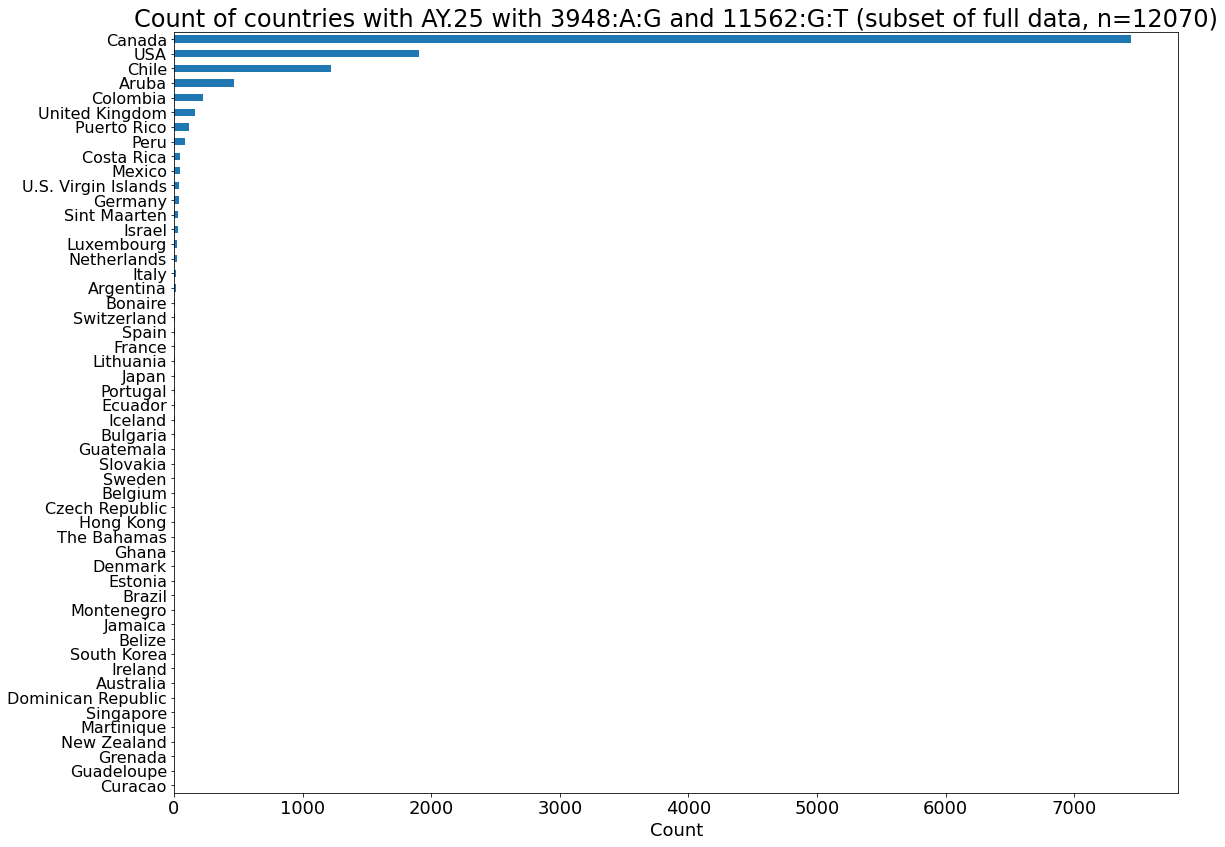

In [100]:
counts_df.set_index('Country').sort_values('Count', ascending=True)['Count'].plot(kind='barh', figsize=(18,14))

plt.title(f'Count of countries with AY.25 with 3948:A:G and 11562:G:T (subset of full data, n={len(df)})', fontdict={'size': 24})
plt.xlabel(f'Count', fontdict={'size': 18})
plt.xticks(fontsize=18)
plt.ylabel('')
plt.yticks(fontsize=16)